In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import  StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer, MinMaxScaler
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
import tensorflow as tf

from keras.models import Sequential,load_model
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, GaussianNoise, Activation
from keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical 
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
#data function for reading and processing the train and test sets
#necessary as an input for the optimisation algorithm
def data():
    #define input processing function
    def process_attributes(df, train, test):
        
        #define and fit the scaler to the full dataset
        cs = MinMaxScaler()
        cs.fit(df_inputs.select_dtypes(np.number))
        
        #scale the numerical input variables
        trainContinuous = cs.transform(train.select_dtypes(np.number))
        testContinuous = cs.transform(test.select_dtypes(np.number))
        
        if 'Gender' in df.columns:
            
            #uncomment the code below to accommodate for any categorical columns
            zipBinarizer = LabelBinarizer().fit(df["Gender"])
            trainCategorical = zipBinarizer.transform(train["Gender"])
            testCategorical = zipBinarizer.transform(test["Gender"])

            # construct our training and testing data points by concatenating
            # the categorical features with the continuous features
            trainX = np.hstack([trainContinuous, trainCategorical])
            testX = np.hstack([testContinuous, testCategorical])
            
        else:
            trainX=trainContinuous
            testX=testContinuous
                
        
        # return the concatenated training and testing data
        return (trainX, testX)
    
    #read the excel datasets
    df = pd.read_excel('Cleaned_Dataframe.xlsx')
    df.set_index('Sample',inplace=True)
    features=df.columns
    
    results_dataframe = pd.read_csv("SurvNet-glycans/result.txt",header = None)
    results_dataframe.columns=['Index','Score']
    results_dataframe['Index'] = results_dataframe['Index'].astype(int)
    reduced_features=features[results_dataframe['Index'].tolist()]
    
    #separate cancer markers and input data
    df_outputs= df['Status']
    df_inputs = df[reduced_features]
    
    X_train, X_test, y_train, y_test = train_test_split(df_inputs, df_outputs, random_state=100, stratify=df_outputs, test_size=0.3)
    
    #process the input sets
    (X_train_sc, X_test_sc) = process_attributes(df_inputs, X_train, X_test)
    
    #encode the categorical output variables
    #encode categorical outputs
    lb = LabelBinarizer()
    lb.fit(y_train)
    train_outputs= lb.transform(y_train)
    test_outputs= lb.transform(y_test)

    Y_train = tf.keras.utils.to_categorical(train_outputs)
    Y_test = tf.keras.utils.to_categorical(test_outputs)

    return X_train_sc, Y_train, X_test_sc, Y_test, lb, reduced_features

In [3]:
#define model and search space for the optimisation algorithm
def model(X_train_sc, Y_train, X_test_sc, Y_test):
    
    #define ANN model and search space
    def ANN():
        
        #define first two layers, possible alternatives for neurons in each,
        #activation function, and dropout layers
        model=Sequential()
        Dropout_rate={{uniform(0, 0.3)}}
        model.add(Dense({{choice([8,16, 24, 32, 64])}}))
        model.add(Activation({{choice(['relu', 'sigmoid', 'tanh'])}}))

        model.add(Dropout(Dropout_rate))

        model.add(Dense({{choice([8,16, 24, 32, 64])}}))
        model.add(Activation({{choice(['relu', 'sigmoid', 'tanh'])}}))

        model.add(Dropout(Dropout_rate))
        
        #define output layer of the model
        
        model.add(Dense(2))
        model.add(Activation('softmax'))
        
        #define optimisation algorithm for network training
        optim=tf.keras.optimizers.Adam(learning_rate={{choice([ 0.001, 0.0005, 0.0001])}})
        
        #compile model and return it
        model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)
        
        return model 
    
    #encode and transform labels for model training
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(np.argmax(Y_train,axis=1))
    
    #call the ANN and ddefine training epochs; define batch size alternatives
    net = KerasClassifier(build_fn = ANN,
                                 epochs={{choice([50,100,200])}},
                                 batch_size= {{choice([32,64])}},
                                 verbose = 0)
    model = ANN()
    
    #set up cross-validation scoring, and returned variables
    c = cross_val_score(net,
                    X_train_sc, y,
                    cv= StratifiedKFold(n_splits=5, shuffle=True),
                    scoring='accuracy').mean()
    print('Test accuracy:', c)
    return {'loss': -c, 'status': STATUS_OK, 'model': model}

In [4]:
#call in data function for test evaluation later
X_train, Y_train, X_test, Y_test, lb, selected_features = data()
print('The model uses the following features:', selected_features)

The model uses the following features: Index(['GP24', 'GP22'], dtype='object')


In [5]:
#call the optimisation algorithm
best_run, best_model = optim.minimize(model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=50,
                                      trials=Trials(),
                                      notebook_name='Reduced_ANN')

>>> Imports:
#coding=utf-8

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from sklearn.pipeline import Pipeline
except:
    pass

try:
    from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer, MinMaxScaler
except:
    pass

try:
    from sklearn.compose import make_column_selector as selector
except:
    pass

try:
    from sklearn.compose import ColumnTransformer
except:
    pass

try:
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from keras.models 

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                        
0.7246169888505655                                    
  2%|▏         | 1/50 [01:00<49:14, 60.29s/trial, best loss: -0.7246169888505655]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7253469158578648                                                               
  4%|▍         | 2/50 [01:39<38:12, 47.76s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7253469158578648                                                               
  6%|▌         | 3/50 [02:36<40:55, 52.25s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7246169888505655                                                               
  8%|▊         | 4/50 [03:03<32:19, 42.16s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7246143151252641                                                               
 10%|█         | 5/50 [03:45<31:25, 41.90s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7253469158578648                                                               
 12%|█▏        | 6/50 [04:29<31:29, 42.94s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7253469158578648                                                               
 14%|█▍        | 7/50 [04:49<25:24, 35.45s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7253469158578648                                                               
 16%|█▌        | 8/50 [05:10<21:28, 30.68s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7253469158578648                                                               
 18%|█▊        | 9/50 [05:58<24:46, 36.25s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7253469158578648                                                               
 20%|██        | 10/50 [06:17<20:27, 30.69s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 22%|██▏       | 11/50 [07:06<23:39, 36.39s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 24%|██▍       | 12/50 [07:28<20:14, 31.96s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7246169888505655                                                                
 26%|██▌       | 13/50 [08:04<20:24, 33.09s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 28%|██▊       | 14/50 [08:34<19:21, 32.28s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 30%|███       | 15/50 [09:01<17:57, 30.78s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 32%|███▏      | 16/50 [09:38<18:32, 32.72s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 34%|███▍      | 17/50 [10:02<16:31, 30.03s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7246169888505655                                                                
 36%|███▌      | 18/50 [10:20<14:05, 26.42s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7246169888505655                                                                
 38%|███▊      | 19/50 [10:42<12:54, 25.00s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7246143151252641                                                                
 40%|████      | 20/50 [11:27<15:29, 30.98s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 42%|████▏     | 21/50 [11:46<13:15, 27.42s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 44%|████▍     | 22/50 [12:09<12:11, 26.12s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 46%|████▌     | 23/50 [12:38<12:07, 26.94s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 48%|████▊     | 24/50 [12:57<10:42, 24.69s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 50%|█████     | 25/50 [13:19<09:54, 23.77s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 52%|█████▏    | 26/50 [13:51<10:28, 26.17s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 54%|█████▍    | 27/50 [14:18<10:08, 26.45s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 56%|█████▌    | 28/50 [14:45<09:48, 26.73s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 58%|█████▊    | 29/50 [15:17<09:54, 28.30s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 60%|██████    | 30/50 [15:37<08:35, 25.79s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 62%|██████▏   | 31/50 [15:55<07:27, 23.56s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 64%|██████▍   | 32/50 [16:27<07:48, 26.01s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 66%|██████▌   | 33/50 [16:53<07:18, 25.82s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 68%|██████▊   | 34/50 [17:14<06:31, 24.49s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 70%|███████   | 35/50 [17:43<06:27, 25.82s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 72%|███████▏  | 36/50 [18:13<06:20, 27.18s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 74%|███████▍  | 37/50 [18:39<05:48, 26.77s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 76%|███████▌  | 38/50 [18:59<04:56, 24.69s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 78%|███████▊  | 39/50 [19:53<06:09, 33.57s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 80%|████████  | 40/50 [20:33<05:54, 35.44s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 82%|████████▏ | 41/50 [21:04<05:06, 34.09s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 84%|████████▍ | 42/50 [21:26<04:03, 30.38s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 86%|████████▌ | 43/50 [21:46<03:10, 27.25s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 88%|████████▊ | 44/50 [22:04<02:27, 24.59s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 90%|█████████ | 45/50 [22:35<02:12, 26.49s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 92%|█████████▏| 46/50 [22:56<01:39, 24.81s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 94%|█████████▍| 47/50 [23:25<01:18, 26.16s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7246143151252641                                                                
 96%|█████████▌| 48/50 [23:58<00:56, 28.17s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
 98%|█████████▊| 49/50 [24:21<00:26, 26.68s/trial, best loss: -0.7253469158578648]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7253469158578648                                                                
100%|██████████| 50/50 [24:43<00:00, 29.66s/trial, best loss: -0.7253469158578648]


In [6]:
#display the parameters for the best performing model
print(best_run)

{'Activation': 1, 'Activation_1': 2, 'Dense': 3, 'Dense_1': 2, 'Dropout_rate': 0.12756858506053687, 'batch_size': 1, 'epochs': 2, 'learning_rate': 0}


In [7]:
best_model

In [8]:
#train the model to gt learning curves
batch=[32,64]
ep=[50,100,200]

history = best_model.fit(
    X_train, Y_train,
    batch_size=batch[best_run['batch_size']],
    epochs=ep[best_run['epochs']],
    verbose=1,
    validation_data=(X_test, Y_test),
    shuffle=False)

Epoch 1/200
22/22 [==============================] - 3s 42ms/step - loss: 0.6111 - accuracy: 0.7351 - val_loss: 0.5886 - val_accuracy: 0.7245
Epoch 2/200
22/22 [==============================] - 0s 6ms/step - loss: 0.5858 - accuracy: 0.7428 - val_loss: 0.5886 - val_accuracy: 0.7245
Epoch 3/200
22/22 [==============================] - 0s 7ms/step - loss: 0.5853 - accuracy: 0.7231 - val_loss: 0.5893 - val_accuracy: 0.7245
Epoch 4/200
22/22 [==============================] - 0s 6ms/step - loss: 0.5978 - accuracy: 0.7292 - val_loss: 0.5886 - val_accuracy: 0.7245
Epoch 5/200
22/22 [==============================] - 0s 6ms/step - loss: 0.5832 - accuracy: 0.7337 - val_loss: 0.5889 - val_accuracy: 0.7245
Epoch 6/200
22/22 [==============================] - 0s 5ms/step - loss: 0.5877 - accuracy: 0.7367 - val_loss: 0.5887 - val_accuracy: 0.7245
Epoch 7/200
22/22 [==============================] - 0s 5ms/step - loss: 0.5966 - accuracy: 0.7330 - val_loss: 0.5894 - val_accuracy: 0.7245
Epoch 8/200


Epoch 59/200
22/22 [==============================] - 0s 3ms/step - loss: 0.5795 - accuracy: 0.7402 - val_loss: 0.5885 - val_accuracy: 0.7245
Epoch 60/200
22/22 [==============================] - 0s 4ms/step - loss: 0.5782 - accuracy: 0.7402 - val_loss: 0.5886 - val_accuracy: 0.7245
Epoch 61/200
22/22 [==============================] - 0s 3ms/step - loss: 0.5791 - accuracy: 0.7402 - val_loss: 0.5885 - val_accuracy: 0.7245
Epoch 62/200
22/22 [==============================] - 0s 3ms/step - loss: 0.5792 - accuracy: 0.7402 - val_loss: 0.5885 - val_accuracy: 0.7245
Epoch 63/200
22/22 [==============================] - 0s 3ms/step - loss: 0.5738 - accuracy: 0.7402 - val_loss: 0.5885 - val_accuracy: 0.7245
Epoch 64/200
22/22 [==============================] - 0s 3ms/step - loss: 0.5774 - accuracy: 0.7402 - val_loss: 0.5885 - val_accuracy: 0.7245
Epoch 65/200
22/22 [==============================] - 0s 5ms/step - loss: 0.5753 - accuracy: 0.7402 - val_loss: 0.5885 - val_accuracy: 0.7245
Epoch 

22/22 [==============================] - 0s 3ms/step - loss: 0.5736 - accuracy: 0.7402 - val_loss: 0.5885 - val_accuracy: 0.7245
Epoch 117/200
22/22 [==============================] - 0s 4ms/step - loss: 0.5764 - accuracy: 0.7402 - val_loss: 0.5885 - val_accuracy: 0.7245
Epoch 118/200
22/22 [==============================] - 0s 3ms/step - loss: 0.5725 - accuracy: 0.7402 - val_loss: 0.5885 - val_accuracy: 0.7245
Epoch 119/200
22/22 [==============================] - 0s 3ms/step - loss: 0.5781 - accuracy: 0.7402 - val_loss: 0.5885 - val_accuracy: 0.7245
Epoch 120/200
22/22 [==============================] - 0s 3ms/step - loss: 0.5730 - accuracy: 0.7402 - val_loss: 0.5886 - val_accuracy: 0.7245
Epoch 121/200
22/22 [==============================] - 0s 3ms/step - loss: 0.5795 - accuracy: 0.7402 - val_loss: 0.5885 - val_accuracy: 0.7245
Epoch 122/200
22/22 [==============================] - 0s 3ms/step - loss: 0.5715 - accuracy: 0.7402 - val_loss: 0.5886 - val_accuracy: 0.7245
Epoch 123/200

22/22 [==============================] - 0s 3ms/step - loss: 0.5764 - accuracy: 0.7402 - val_loss: 0.5885 - val_accuracy: 0.7245
Epoch 174/200
22/22 [==============================] - 0s 3ms/step - loss: 0.5742 - accuracy: 0.7402 - val_loss: 0.5885 - val_accuracy: 0.7245
Epoch 175/200
22/22 [==============================] - 0s 3ms/step - loss: 0.5776 - accuracy: 0.7402 - val_loss: 0.5885 - val_accuracy: 0.7245
Epoch 176/200
22/22 [==============================] - 0s 3ms/step - loss: 0.5742 - accuracy: 0.7402 - val_loss: 0.5885 - val_accuracy: 0.7245
Epoch 177/200
22/22 [==============================] - 0s 3ms/step - loss: 0.5737 - accuracy: 0.7402 - val_loss: 0.5885 - val_accuracy: 0.7245
Epoch 178/200
22/22 [==============================] - 0s 3ms/step - loss: 0.5736 - accuracy: 0.7402 - val_loss: 0.5885 - val_accuracy: 0.7245
Epoch 179/200
22/22 [==============================] - 0s 3ms/step - loss: 0.5771 - accuracy: 0.7402 - val_loss: 0.5885 - val_accuracy: 0.7245
Epoch 180/200

In [9]:
#save resulting model in callable file
best_model.summary()
best_model.save('ANN Models/reduced_inputs_model.h5')
print("Saved model to directory")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 32)                96        
_________________________________________________________________
activation_18 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 24)                792       
_________________________________________________________________
activation_19 (Activation)   (None, 24)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                

In [10]:
#Calculate the labels for the test set
predictions = best_model.predict(X_test)

In [11]:
#evaluate test performance of the model
print('Cancer is encoded by',lb.transform(['Cancer']), ', while Control is encoded by',lb.transform(['Control']))
print(confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(predictions, axis=1)))
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(predictions, axis=1), target_names=lb.classes_))

Cancer is encoded by [[0]] , while Control is encoded by [[1]]
[[426   0]
 [162   0]]
              precision    recall  f1-score   support

      Cancer       0.72      1.00      0.84       426
     Control       0.00      0.00      0.00       162

    accuracy                           0.72       588
   macro avg       0.36      0.50      0.42       588
weighted avg       0.52      0.72      0.61       588



C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


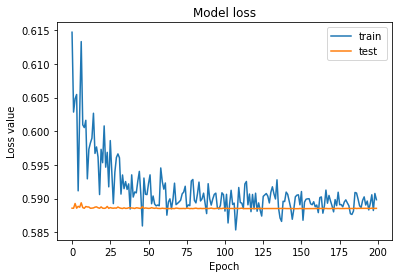

In [13]:
from matplotlib import pyplot as plt
# Visualize history
# Plot history: Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

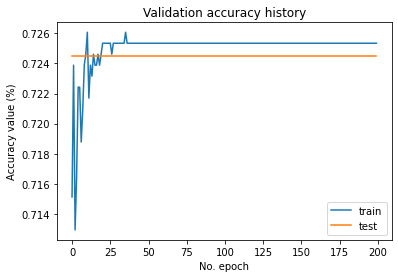

In [14]:
# Plot history: Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()